> ScribeSmith - deep learning model to synthesize handwriting
>
> Copyright © 2023 The ScribeSmith developers (see [README](../README.md#developers))
>
> This program is free software: you can redistribute it and/or modify 
> it under the terms of the GNU General Public License as published by
> the Free Software Foundation, version 3.
> 
> This program is distributed in the hope that it will be useful,
> but WITHOUT ANY WARRANTY; without even the implied warranty of
> MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
> GNU General Public License for more details.
>
> You should have received a copy of the GNU General Public License
> along with this program. If not, see <http://www.gnu.org/licenses/>.

# Baseline Model for Handwritten Text Synthesis

In [1]:
import os
from PIL import Image
import numpy as np
import glob
import random
import matplotlib.pyplot as plt

import csv
import datetime
import os
import random
import re
import requests

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch_fidelity
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from torch.nn.utils.spectral_norm import spectral_norm
from torch.utils.data import DataLoader, Dataset, RandomSampler, Subset, random_split
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import Grayscale, Resize, ToTensor, ToPILImage
from torchvision.transforms.functional import InterpolationMode
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# import pytesseract

random.seed(42)

DATA_DIR = "./../data"
CHARS_DIR = os.path.join(DATA_DIR, "chars")
OUT_IMG_WIDTH = 512*4
OUT_IMG_HEIGHT = 32*4

# Sorted by ascii code
valid_chars = [
    ' ', '!', '"', "'", ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    ':', ';', '?',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]
# Enumerate from 1 to save space for padding
char_to_int = {v: i for i, v in enumerate(valid_chars, 1)}
int_to_char = {i: v for i, v in enumerate(valid_chars, 1)}


/home/kevin/miniconda3/envs/scribesmith/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Processing

In [2]:
def get_char_filenames(char, extension=""):
    char_id = str(char_to_int[char]).zfill(2)
    filenames = glob.glob(os.path.join(CHARS_DIR, char_id, f"{char_id}-*{extension}"))
    return filenames


In [3]:
def process_img(img, new_height=OUT_IMG_HEIGHT, threshold=230):
    # Scale image
    width, height = img.size
    print(np.array(img))
    new_width = int((new_height / height) * width)
    # output = cv.resize(np.array(img), (new_width, new_height), interpolation=cv.INTER_AREA)
    scaled_img = img.resize((new_width, new_height), resample=Image.AFFINE)

    # scaled_img = output

    # Binarize image
    img_arr = np.array(scaled_img.convert("L"), dtype=np.uint8)
    bin_img = np.where(img_arr > threshold, 255, 0)
    print(bin_img)

    # Crop horizontal padding
    non_empty_columns = np.where(bin_img.max(axis=0) > 0)[0]
    return bin_img[:, min(non_empty_columns) : max(non_empty_columns) + 1]


def process_char_img(filename):
    img = Image.open(filename + ".png")
    img = process_img(img)
    np.save(filename + ".npy", img)  # Save as a numpy array


In [4]:
# Process every file
for char in valid_chars:
    for filename in get_char_filenames(char, ".png"):
        filename = filename[:-4]  # Remove file extension
        process_char_img(filename)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [2

## Generate Handwriting

In [5]:
def get_rand_img_arr(char):
    filenames = get_char_filenames(char, ".npy")
    rand_img = np.load(random.choice(filenames))
    return rand_img


def gen_hand_text(text):
    chars = list(text)

    # Initialize a white array of size 1x128x2048
    res_array = np.full((OUT_IMG_HEIGHT, OUT_IMG_WIDTH), 255, dtype=np.uint8)

    x_offset = 0
    for char in chars:
        if char == " ":
            # Add random spacing between words
            space_width = random.randint(50, 60)
            if x_offset + space_width <= OUT_IMG_WIDTH:
                x_offset += space_width
        else:
            char_array = get_rand_img_arr(char)
            if x_offset + char_array.shape[1] <= OUT_IMG_WIDTH:
                res_array[:, x_offset : x_offset + char_array.shape[1]] = char_array
                x_offset += char_array.shape[1]
                # Add random spacing between letters
                space_width = random.randint(5, 8)
                if x_offset + space_width <= OUT_IMG_WIDTH:
                    x_offset += space_width

    return res_array


def gen_hand_lines(lines):
    # Initialize an empty list to store arrays
    arrays = []
    for line in lines:
        array = gen_hand_text(line)
        # print(array.shape)
        output = cv.resize(np.array(array), (512, 32), interpolation=cv.INTER_AREA)
        arrays.append(torch.tensor(output))
        print(arrays)

    for i in arrays:
        print(i.shape)
    # Stack arrays along the first axis
    result = np.stack(arrays, axis=0)
    print(result.shape)
    # Reshape to Nx1x128x2048
    result = result.reshape(len(lines), 1, 32, 512)
    return result


In [6]:
def disp_imgs(imgs):
    for i, img in enumerate(imgs):
        plt.figure(i)
        plt.imshow(img[0], cmap="gray")
        # plt.axis("off")
    plt.show()


3
[tensor([[255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        ...,
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255]], dtype=torch.uint8)]
[tensor([[255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        ...,
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255]], dtype=torch.uint8), tensor([[255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        ...,
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255]], dtype=torch.uint8)]
[tensor([[255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 

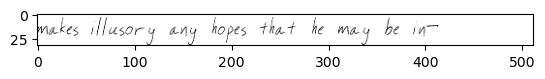

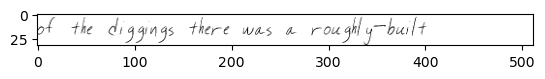

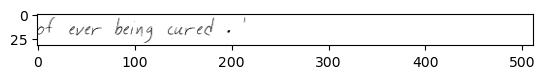

In [7]:
#lines = ["Hello World,", "this is the baseline model!", "2 x 2 : 4"]
lines = ['makes illusory any hopes that he may be in-', 'of the diggings there was a roughly-built', "of ever being cured . '"]
print(len(lines))

imgs = gen_hand_lines(lines)
print(imgs.shape, type(imgs))
torch.save(torch.tensor(imgs), "baseline_model_outputs.pt")
disp_imgs(imgs)

# def Recognizer_Py(img):
#         to_pil_image = ToPILImage()
#         img = to_pil_image(img)

#         string_rep = pytesseract.image_to_string(img)
#         string_rep = string_rep.replace('\n', '')

#         print(string_rep, "\n")


#         vec_rep = [char_to_int[i] for i in string_rep]
#         embedding = torch.FloatTensor(vec_rep)

#         return embedding

# print(Recognizer_Py(np.squeeze(imgs)))